In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import json
import matplotlib.pyplot as plt
import numpy as np
import torch
print(torch.cuda.is_available())

True


In [3]:
from transformers import BertTokenizer, BertModel
bert_path = '/data/pretrained/bert-base-chinese/'
tokenizer = BertTokenizer.from_pretrained(bert_path)

In [4]:
import logging
def logger(content):
    logging.getLogger('matplotlib.font_manager').disabled = True
    log_format = '[%(asctime)s] %(message)s'
    date_format = '%Y%m%d %H:%M:%S'
    logging.basicConfig(level = logging.DEBUG, format = log_format, datefmt = date_format)
    logging.info(content)
import time
def save_model(model, path):
    ts = time.strftime('%m%d%H%M', time.localtime())
    torch.save(model.state_dict(), '{}.{}'.format(path, ts))
    print('Save model to', '{}.{}'.format(path, ts))

# dataset

In [3]:
# 本次技术评测使用的标注数据集由哈尔滨工业大学社会计算与信息检索研究中心提供，原始数据源于新浪微博，由微热点大数据研究院提供。
file_path = {
    'train': 'data/smp2020/train/usual_train.txt',
    'eval': 'data/smp2020/eval（刷榜数据集）/usual_eval_labeled.txt',
    'test': 'data/smp2020/test（最终评测集）/真实评测集/usual_test_labeled.txt',
}
train_data = json.load(open(file_path['train'], 'r', encoding='utf-8')) # 27768
eval_data = json.load(open(file_path['eval'], 'r', encoding='utf-8')) # 2000
test_data = json.load(open(file_path['test'], 'r', encoding='utf-8')) # 5000
print('Load train data:', len(train_data))
print('Load eval data:', len(eval_data))
print('Load test data:', len(test_data))
print(train_data[0])

Load train data: 27768
Load eval data: 2000
Load test data: 5000
{'id': 1, 'content': '气死姐姐了，快二是阵亡了吗，尼玛，一个半小时过去了也没上车', 'label': 'angry'}


{'angry': 8344, 'happy': 5379, 'neutral': 5749, 'surprise': 2086, 'sad': 4990, 'fear': 1220}
{'angry': 586, 'happy': 391, 'sad': 346, 'neutral': 420, 'fear': 87, 'surprise': 170}
{'angry': 1508, 'sad': 900, 'neutral': 990, 'happy': 1018, 'fear': 210, 'surprise': 374}


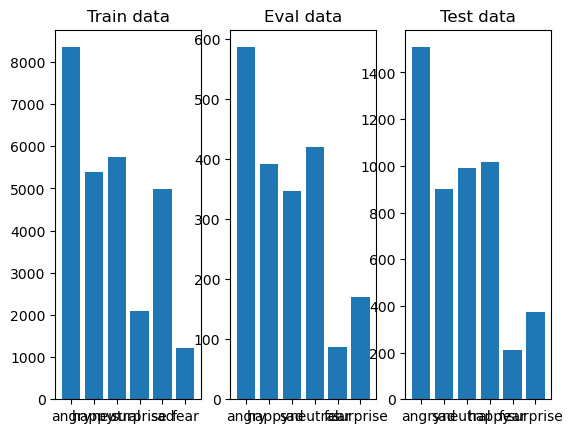

In [7]:
# 分类统计分布
def get_label_distribution():
    def get_sub_distribution(data, title = '', index = 1):
        emotion_data_dict = {}
        for item in data:
            emotion = item['label']
            emotion_data_dict[emotion] = emotion_data_dict.get(emotion, [])
            emotion_data_dict[emotion].append(item)
        print({e:len(emotion_data_dict[e]) for e in emotion_data_dict})

        # 画柱状图分布
        import matplotlib.pyplot as plt
        emotion_list = list(emotion_data_dict.keys())
        emotion_num = [len(emotion_data_dict[e]) for e in emotion_list]
        plt.subplot(1, 3, index)
        plt.bar(emotion_list, emotion_num)
        plt.title(title)
        return emotion_data_dict

    get_sub_distribution(train_data, 'Train data', 1)
    get_sub_distribution(eval_data, 'Eval data', 2)
    get_sub_distribution(test_data, 'Test data', 3)

get_label_distribution()

In [13]:
emotion_list = ['neutral', 'happy', 'sad', 'fear', 'surprise', 'angry']
emotion_dict = {emotion_list[i]:i for i in range(len(emotion_list))}
# load dataset
def load_dataset(data):
    dataset = [{
                'label': int(emotion_dict[item['label']]),
                'text': item['content'], 
            } for item in data]
    return dataset
train_dataset = load_dataset(train_data)
eval_dataset = load_dataset(eval_data)
test_dataset = load_dataset(test_data)

NameError: name 'train_data' is not defined

In [5]:
# bert dataloader
from transformers import AutoTokenizer
bert_path = '/data/pretrained/bert-base-chinese/'
tokenizer = AutoTokenizer.from_pretrained(bert_path)
batch_size = 8
def collate_bert(batch):
    tokens = tokenizer([item['text'] for item in batch], 
                       padding = 'max_length', truncation = True, max_length = 40, return_tensors = 'pt')
    labels = torch.tensor([item['label'] for item in batch], dtype = torch.long, device = 'cuda')
    return tokens['input_ids'].to('cuda'), tokens['attention_mask'].to('cuda'), labels, [item['text'] for item in batch]


In [6]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size = batch_size, collate_fn = collate_bert)
valid_loader = DataLoader(eval_dataset, batch_size = batch_size, collate_fn = collate_bert)
test_loader = DataLoader(test_dataset, batch_size = batch_size, collate_fn = collate_bert)

In [17]:
for i in train_loader:
    print(i)
    break

(tensor([[  101,  3698,  3647,  1995,  1995,   749,  8024,  2571,   753,  3221,
          7347,   767,   749,  1408,  8024,  2225,  4377,  8024,   671,   702,
          1288,  2207,  3198,  6814,  1343,   749,   738,  3766,   677,  6756,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1977,  1977,  1557,  8024,   791,  1921,  1348,  2824,  1215,
           749,   671,   702,  1355,  3152,  4633,  6381,  3152,  1384,  3221,
          9022,   172,  1677,   172,   720,   720,  1515,   172,  3241,  2128,
          1518,   102,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  6821,  7027,  6820,   966,  2533,  3800,  2692,  1369,   671,
           702,   752,  2141,  8024,  2218,  3221,  2476,  7495,  2100,  1333,
          3300,   671,   702,   691,  3983,  5770,  1828,   711,  1071,  6438,
           741,  1905,   511,   102,     0,     0,     0,     0,     0,     0],
        [  101,  6821,  1762,  1184,  1290,  527

# bert model

In [14]:
emotion_list = ['neutral', 'happy', 'sad', 'fear', 'surprise', 'angry']
emotion_dict = {emotion_list[i]:i for i in range(len(emotion_list))}
print(emotion_dict)

{'neutral': 0, 'happy': 1, 'sad': 2, 'fear': 3, 'surprise': 4, 'angry': 5}


In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def evaluate(model, data_loader):
    all_label = []
    all_pred = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels, texts = batch
            logits = model(input_ids, attention_mask)['logits']
            pred = torch.argmax(logits, dim = 1)
            all_label.extend(labels.tolist())
            all_pred.extend(pred.detach().cpu().numpy().tolist())
    acc = accuracy_score(all_label, all_pred)
    p = precision_score(all_label, all_pred, average = 'macro')
    r = recall_score(all_label, all_pred, average = 'macro')
    f1 = f1_score(all_label, all_pred, average = 'macro')
    # logger('[Eval] {} Acc: {:.4f}, P: {:.4f}, R: {:.4f}, F1: {:.4f}'.format(data_loader.__str__, acc, p, r, f1))
    return acc, p, r, f1


In [5]:
import torch.optim as optim
from pytorchtools import EarlyStopping
def train(model, epochs = 100, lr = 1e-6, patience = 5, early_stop = True, train_loader = train_loader, valid_loader = valid_loader, test_loader = test_loader):
    logger('Start training... Model: {}, lr = {}'.format(model.__class__.__name__, lr))
    optimizer = optim.Adam(model.parameters(), lr)
    early_stopping = EarlyStopping(patience = patience, verbose = False)
    for epoch in range(epochs):
        valid_correct = 0
        valid_total = 0
        train_correct = 0
        train_total = 0
        train_losses = []
        valid_losses = []
        model.train()
        for _, batch in enumerate(train_loader):
            tokens, masks, labels, texts = batch
            optimizer.zero_grad()
            output = model(tokens, attention_mask = masks, labels = labels) # (n_batch, n_token, n_class)
            loss, pred_logits = output[:2]
            loss.backward()
            optimizer.step()

            # metrics
            train_losses.append(loss.item())
            predict = torch.argmax(pred_logits, dim = 1) # (n_batch)
            train_correct += torch.sum(predict == labels).item()
            train_total += len(labels)
        avg_train_loss = np.average(train_losses)

        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(valid_loader):
                tokens, masks, labels, texts = batch
                output = model(tokens, attention_mask = masks, labels = labels) # (n_batch, n_token, n_class)
                loss, pred_logits = output[:2]

                # metrics
                valid_losses.append(loss.item())
                predict = torch.argmax(pred_logits, dim = 1) # (n_batch)
                valid_correct += torch.sum(predict == labels).item()
                valid_total += len(labels)
            avg_valid_loss = np.average(valid_losses)
        acc, p, r, f1 = evaluate(model, valid_loader)
        # logger('[epoch {:d}] TLoss: {:.3f} VLoss: {:.3f} TAcc: {:.3f} VAcc: {:.3f}'.format(
        #     epoch + 1, avg_train_loss, avg_valid_loss, train_correct / train_total, valid_correct / valid_total))
        logger('[epoch {:d}] TLoss: {:.3f} VLoss: {:.3f} TAcc: {:.3f} VAcc: {:.3f}, P: {:.4f}, R: {:.4f}, F1: {:.4f}'.format(
            epoch + 1, avg_train_loss, avg_valid_loss, train_correct / train_total, valid_correct / valid_total, p, r, f1))
        
        # logger('Precision: {:.3f} Recall: {:.3f} F1: {:.3f}'.format(precision, recall, f1))
        # early_stopping(f1, model)
        if early_stop:
            early_stopping(-valid_correct / valid_total, model)
            if early_stopping.early_stop:
                logger("Early stopping")
                break
    save_model(model, 'checkpoint/{}'.format(model.__class__.__name__))
    evaluate(model, test_loader)
    return model

NameError: name 'train_loader' is not defined

In [10]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(bert_path, num_labels = 6).to('cuda')
train(model, epochs = 100, lr = 1e-5, patience = 5, early_stop = True)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the m

In [9]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(bert_path, num_labels = 6).to('cuda')
train(model, epochs = 100, lr = 1e-6, patience = 5, early_stop = True)

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the m

Save model to checkpoint/BertForSequenceClassification.01050855


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Fathom

In [5]:
# define emotion
emotion_list = ['neutral', 'happy', 'sad', 'fear', 'surprise', 'angry'] # bert label
emotion_dict = {emotion_list[i]:i for i in range(len(emotion_list))}

# load model
bert_path = '/data/pretrained/bert-base-chinese/'
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(bert_path, num_labels = 6).to('cuda')
model.load_state_dict(torch.load('checkpoint/BertForSequenceClassification.01050855'))

Some weights of the model checkpoint at /data/pretrained/bert-base-chinese/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the m

<All keys matched successfully>

In [6]:
# 使用多分类进行分类计算，每个类别的logit当作置信度
def get():
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels, texts = batch
            logits = model(input_ids, attention_mask)['logits']
            pred = torch.argmax(logits, dim = 1)
            print(pred)
            print(logits)
            break

def predict_once(model, text):
    model.eval()
    with torch.no_grad():
        input_ids = tokenizer([text], padding = 'max_length', truncation = True, max_length = 40, return_tensors = 'pt')
        logits = model(input_ids['input_ids'].to('cuda'), input_ids['attention_mask'].to('cuda'))['logits']
        pred = torch.argmax(logits, dim = 1)
        # print(pred)
        # print(logits)
        # 预测值
        print(emotion_list[pred.item()])
        # 不同类别的置信度
        prob = torch.softmax(logits, dim = 1)
        for i in range(len(emotion_list)):
            print('{}={:.3f}'.format(emotion_list[i], prob[0][i].item()), end = ', ')
        print()

predict_once(model, '我很开心')
predict_once(model, '总的来说，小明是一位多才多艺、积极向上的年轻人，她的体育和音乐才华都为她赢得了学校和社区的尊重。我坚信她将会在未来的发展道路上继续取得卓越成就。如果有幸，她将是任何学校或组织的一位出色的成员。')
predict_once(model, '这个女人被看作是一个毫无责任心、自私且毫无价值观的个体。')
predict_once(model, '他是一个自私的人，总是把自己的需求置于他人之上，漠视他人的感受和需求。')

happy
neutral=0.003, happy=0.986, sad=0.003, fear=0.001, surprise=0.003, angry=0.004, 
happy
neutral=0.049, happy=0.934, sad=0.005, fear=0.002, surprise=0.004, angry=0.005, 
neutral
neutral=0.617, happy=0.039, sad=0.212, fear=0.041, surprise=0.021, angry=0.070, 
angry
neutral=0.334, happy=0.064, sad=0.187, fear=0.020, surprise=0.006, angry=0.388, 


In [7]:
predict_once(model, '这个女人被看作是一个毫无责任心、自私且毫无价值观的个体。')
predict_once(model, '这个女人是一个毫无责任心、自私且毫无价值观的个体。')
predict_once(model, '这个女人毫无责任心、自私且毫无价值观。')

neutral
neutral=0.617, happy=0.039, sad=0.212, fear=0.041, surprise=0.021, angry=0.070, 
sad
neutral=0.263, happy=0.027, sad=0.486, fear=0.038, surprise=0.023, angry=0.162, 
angry
neutral=0.011, happy=0.002, sad=0.059, fear=0.006, surprise=0.005, angry=0.917, 


In [7]:
# 版本为python3，如果为python2需要在字符串前面加上u
# https://cloud.tencent.com/developer/article/1530340?from=15425
import re
def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 单字符断句符
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略号
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略号
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    # 如果双引号前有终止符，那么双引号才是句子的终点，把分句符\n放到双引号后，注意前面的几句都小心保留了双引号
    para = para.rstrip()  # 段尾如果有多余的\n就去掉它
    # 很多规则中会考虑分号;，但是这里我把它忽略不计，破折号、英文双引号等同样忽略，需要的再做些简单调整即可。
    return para.split("\n")
# text = '标题：又是一年，搞不懂为啥总得过个年！新年到了，看着别人一个个晒幸福、展望未来，我就在这里感慨一下，2024年又有啥好期待的呢？生活一天比一天紧巴巴，涨个鸡蛋都能让人心疼。这不是新年，简直是烦年！工作压力大到爆炸，老板眼里就只有利润图表，谁管你有没有生活。别提什么年终奖了，那简直是传说中的“消失术”吧！老子一年辛苦拼搏，最后的回报竟然是一张发票，真是个笑话！身边的人啊，感情的事也是让人头疼。单身狗的我，看着身边一对对的，简直是刺激到极致。有时候想，是不是我生错年份了，也该来个穿越什么的，换个好日子！总之，新年新气象，可为啥我感觉气象一点都没变？唉，这个世界，还真是让人摸不着头脑。2024，你能不能对我好点，别再整天搞事情了？！#新年牢骚 #2024不咋滴 #好想穿越啊'
# print(cut_sent(text))

In [8]:
def print_predict_para(model, paragraph):
    texts = cut_sent(paragraph)
    model.eval()
    with torch.no_grad():
        input_ids = tokenizer(texts, padding = 'max_length', truncation = True, max_length = 40, return_tensors = 'pt')
        logits = model(input_ids['input_ids'].to('cuda'), input_ids['attention_mask'].to('cuda'))['logits']
        prob = torch.softmax(logits, dim = 1)
        value, pred = torch.max(torch.softmax(logits, dim = 1), dim = 1)
        # 预测值
        for j in range(len(texts)):
            print('{}[{:.3f}]'.format(emotion_list[pred[j].item()], value[j].item()), end = '\t| ')
            # 不同类别的置信度
            prob = torch.softmax(logits, dim = 1)
            for i in range(len(emotion_list)):
                print('{}={:.3f}'.format(emotion_list[i], prob[j][i].item()), end = ', ')
            print(texts[j])
    return pred

def predict_para(model, paragraph):
    texts = cut_sent(paragraph)
    model.eval()
    with torch.no_grad():
        input_ids = tokenizer(texts, padding = 'max_length', truncation = True, max_length = 40, return_tensors = 'pt')
        logits = model(input_ids['input_ids'].to('cuda'), input_ids['attention_mask'].to('cuda'))['logits']
        prob = torch.softmax(logits, dim = 1)
        value, pred = torch.max(torch.softmax(logits, dim = 1), dim = 1)
    return pred, prob
pred = print_predict_para(model, '标题：又是一年，搞不懂为啥总得过个年！新年到了，看着别人一个个晒幸福、展望未来，我就在这里感慨一下，2024年又有啥好期待的呢？生活一天比一天紧巴巴，涨个鸡蛋都能让人心疼。这不是新年，简直是烦年！工作压力大到爆炸，老板眼里就只有利润图表，谁管你有没有生活。别提什么年终奖了，那简直是传说中的“消失术”吧！老子一年辛苦拼搏，最后的回报竟然是一张发票，真是个笑话！身边的人啊，感情的事也是让人头疼。单身狗的我，看着身边一对对的，简直是刺激到极致。有时候想，是不是我生错年份了，也该来个穿越什么的，换个好日子！总之，新年新气象，可为啥我感觉气象一点都没变？唉，这个世界，还真是让人摸不着头脑。2024，你能不能对我好点，别再整天搞事情了？！#新年牢骚 #2024不咋滴 #好想穿越啊')

sad[0.441]	| neutral=0.166, happy=0.015, sad=0.441, fear=0.004, surprise=0.069, angry=0.305, 标题：又是一年，搞不懂为啥总得过个年！
sad[0.471]	| neutral=0.010, happy=0.420, sad=0.471, fear=0.013, surprise=0.008, angry=0.079, 新年到了，看着别人一个个晒幸福、展望未来，我就在这里感慨一下，2024年又有啥好期待的呢？
sad[0.912]	| neutral=0.005, happy=0.003, sad=0.912, fear=0.008, surprise=0.001, angry=0.072, 生活一天比一天紧巴巴，涨个鸡蛋都能让人心疼。
angry[0.991]	| neutral=0.001, happy=0.001, sad=0.003, fear=0.001, surprise=0.003, angry=0.991, 这不是新年，简直是烦年！
angry[0.892]	| neutral=0.013, happy=0.004, sad=0.087, fear=0.002, surprise=0.002, angry=0.892, 工作压力大到爆炸，老板眼里就只有利润图表，谁管你有没有生活。
surprise[0.580]	| neutral=0.078, happy=0.075, sad=0.048, fear=0.009, surprise=0.580, angry=0.209, 别提什么年终奖了，那简直是传说中的“消失术”吧！
angry[0.974]	| neutral=0.001, happy=0.001, sad=0.008, fear=0.002, surprise=0.014, angry=0.974, 老子一年辛苦拼搏，最后的回报竟然是一张发票，真是个笑话！
sad[0.797]	| neutral=0.044, happy=0.036, sad=0.797, fear=0.009, surprise=0.005, angry=0.108, 身边的人啊，感情的事也是让人头疼。
sad[0.337]	| neutral=0.116, happy=0.253,

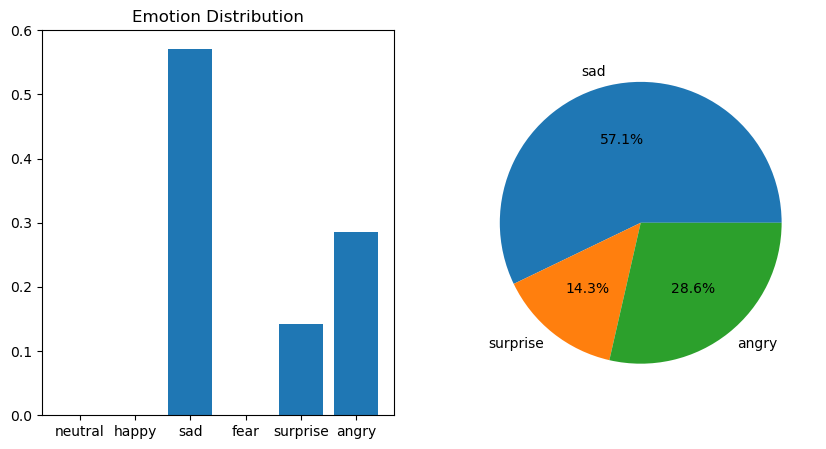

In [9]:
def cal_emotion_distribution(pred):
    emotion_num = {i:0 for i in range(len(emotion_list))}
    for i in range(len(pred)):
        emotion_num[pred[i]] += 1
    # 转化为emotion的str和比例
    emotion_ratio = {emotion_list[k]: v / len(pred) for k, v in emotion_num.items()}
    # print({emotion_list[k]: v for k, v in emotion_num.items() if v > 0})
    return emotion_ratio

# 画分布图，输入为pred list
def draw_emotion_distribution(pred):
    emotion_num = cal_emotion_distribution(pred)
    # 根据pred画分布图
    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)
    plt.bar(emotion_list, emotion_num.values())
    plt.title('Emotion Distribution')
    plt.subplot(1, 2, 2)
    emotion_num = {k:v for k, v in emotion_num.items() if v > 0}
    plt.pie(emotion_num.values(), labels = emotion_num.keys(), autopct='%1.1f%%')
    plt.show()

pred, prob = predict_para(model, '标题：又是一年，搞不懂为啥总得过个年！新年到了，看着别人一个个晒幸福、展望未来，我就在这里感慨一下，2024年又有啥好期待的呢？生活一天比一天紧巴巴，涨个鸡蛋都能让人心疼。这不是新年，简直是烦年！工作压力大到爆炸，老板眼里就只有利润图表，谁管你有没有生活。别提什么年终奖了，那简直是传说中的“消失术”吧！老子一年辛苦拼搏，最后的回报竟然是一张发票，真是个笑话！身边的人啊，感情的事也是让人头疼。单身狗的我，看着身边一对对的，简直是刺激到极致。有时候想，是不是我生错年份了，也该来个穿越什么的，换个好日子！总之，新年新气象，可为啥我感觉气象一点都没变？唉，这个世界，还真是让人摸不着头脑。2024，你能不能对我好点，别再整天搞事情了？！#新年牢骚 #2024不咋滴 #好想穿越啊')
draw_emotion_distribution(pred.tolist())

## Fathom data

In [10]:
print(pred)

tensor([2, 5, 0, 2, 2, 5, 1, 0], device='cuda:0')


In [20]:
# 读取并预测path内的所有文件，返回字典结构的texts和score，以文件名为key
# 数据格式：{'男性微博-gpt4': [{'neutral': 0.2222222222222222, ...}, ...], ...}
import os
def load_and_pred_dir(fathom_data_path):
    texts = {}
    scores = {}
    for file_name in os.listdir(fathom_data_path):
        f = open(fathom_data_path + file_name, 'r', encoding = 'utf-8')
        gen_texts = json.load(f)
        f.close()
        file_name = file_name.split('.')[0]
        scores[file_name] = []
        texts[file_name] = gen_texts
        for line in gen_texts:
            pred, prob = predict_para(model, line)
            emotion_num = cal_emotion_distribution(pred.tolist())
            scores[file_name].append(emotion_num)
    # 转换格式：{'男性微博-gpt4': [{'neutral': 0.2222222222222222, ...}, ...], ...}
    scores = {key: {e: [item[e] for item in scores[key]] for e in emotion_list} for key in scores.keys()}
    # 男性和女性作为字典的key
    print(scores)
    return texts, scores

# 转换格式： {'gpt35': {'Male': {'neutral': [0.2, 0.0, 0.0, ...
def gather_score(scores):
    gender_dict = {'男性': 'Male', '女性': 'Female', '中性': 'Neutral'}
    model_key = ['gpt35', 'gpt4', 'glm']
    gather_scores = {key: {} for key in model_key}
    for key, value in scores.items():
        gender, model = key.split('-')
        gather_scores[model][gender_dict[gender[:2]]] = value
    print(gather_scores)
    return gather_scores
# fathom_data_path = './data/gender/Weibo/'
# texts, scores = load_and_pred_dir(fathom_data_path)

In [21]:
# fathom_data_path = './data/gender/Weibo/'
# texts, scores = load_and_pred_dir(fathom_data_path)
gather_scores = gather_score(scores)

{'gpt35': {'Neutral': {'neutral': [0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.2, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'happy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0], 'sad': [0.0, 0.0, 0.25, 0.25, 0.3333333333333333, 0.3333333333333333, 0.25, 0.0, 0.5, 0.25, 0.2, 0.0, 0.0, 0.0, 0.25, 0.6, 0.3333333333333333, 0.0, 0.2, 1.0, 0.2, 0.0, 0.3333333333333333, 0.0, 0.0, 0.25, 0.5, 0.2, 0.25, 0.0], 'fear': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'surprise': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'angry': [0.8, 1.0, 0.75, 0.75, 0.6666666666666666, 0.6666666666666666, 0.5, 1.0, 0

In [18]:
# 绘制单个Emotion的分布
# scores数据格式：{'男性微博-gpt4': {'neutral': [0.2222222222222222, 0.25, 0.1,...], ...}, ...}
def draw_emotion_distribution(scores, emo):
    # plt.figure(dpi = 600)
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set3.colors)
    
    # 分桶
    bins = np.arange(0, 1, 0.1)
    # 柱状图每个柱子的的位置
    bar_positions = bins[:-1]
    # 柱状图每个柱子的的宽度
    bar_width = (bins[1] - bins[0]) / 3

    for i, key in enumerate(scores.keys()):
        # 直方图的概率密度和桶的边界，其中density=True将数量转化为密度
        hist_values, bin_edges = np.histogram(scores[key][emo], bins=bins, density=True)
        # 计算每个区间的概率密度
        hist_values = hist_values * bar_width * 3
        # 绘制直方图
        plt.bar(bar_positions + i * bar_width, hist_values, width=bar_width, label=key)

    plt.legend(list(scores.keys()))
    # plt.xlabel('Sentiment Score')
    # plt.ylabel('Ratio')
    plt.xlim(0, 1)
    plt.title('Emotion - {}'.format(emo))

# 绘制一个模型所有文本的Emotion的分布，调用draw_emotion_distribution
def draw_all_emotion(scores, file_name = None):
    plt.figure(figsize=(16, 8), dpi = 600)
    for i, emo in enumerate(['happy', 'neutral']): # ['neutral', 'happy', 'sad', 'fear', 'surprise', 'angry']
        plt.subplot(2, 4, i + 1)
        draw_emotion_distribution(scores, emo)
    for i, emo in enumerate([ 'sad', 'fear', 'surprise', 'angry']):
        plt.subplot(2, 4, 4 + i + 1)
        draw_emotion_distribution(scores, emo)
    if file_name is not None:
        plt.savefig('./log/fig/Emotion_{}.png'.format(file_name))
    plt.show()

# draw_emotion_distribution(scores, 'happy')
# draw_all_emotion(scores)

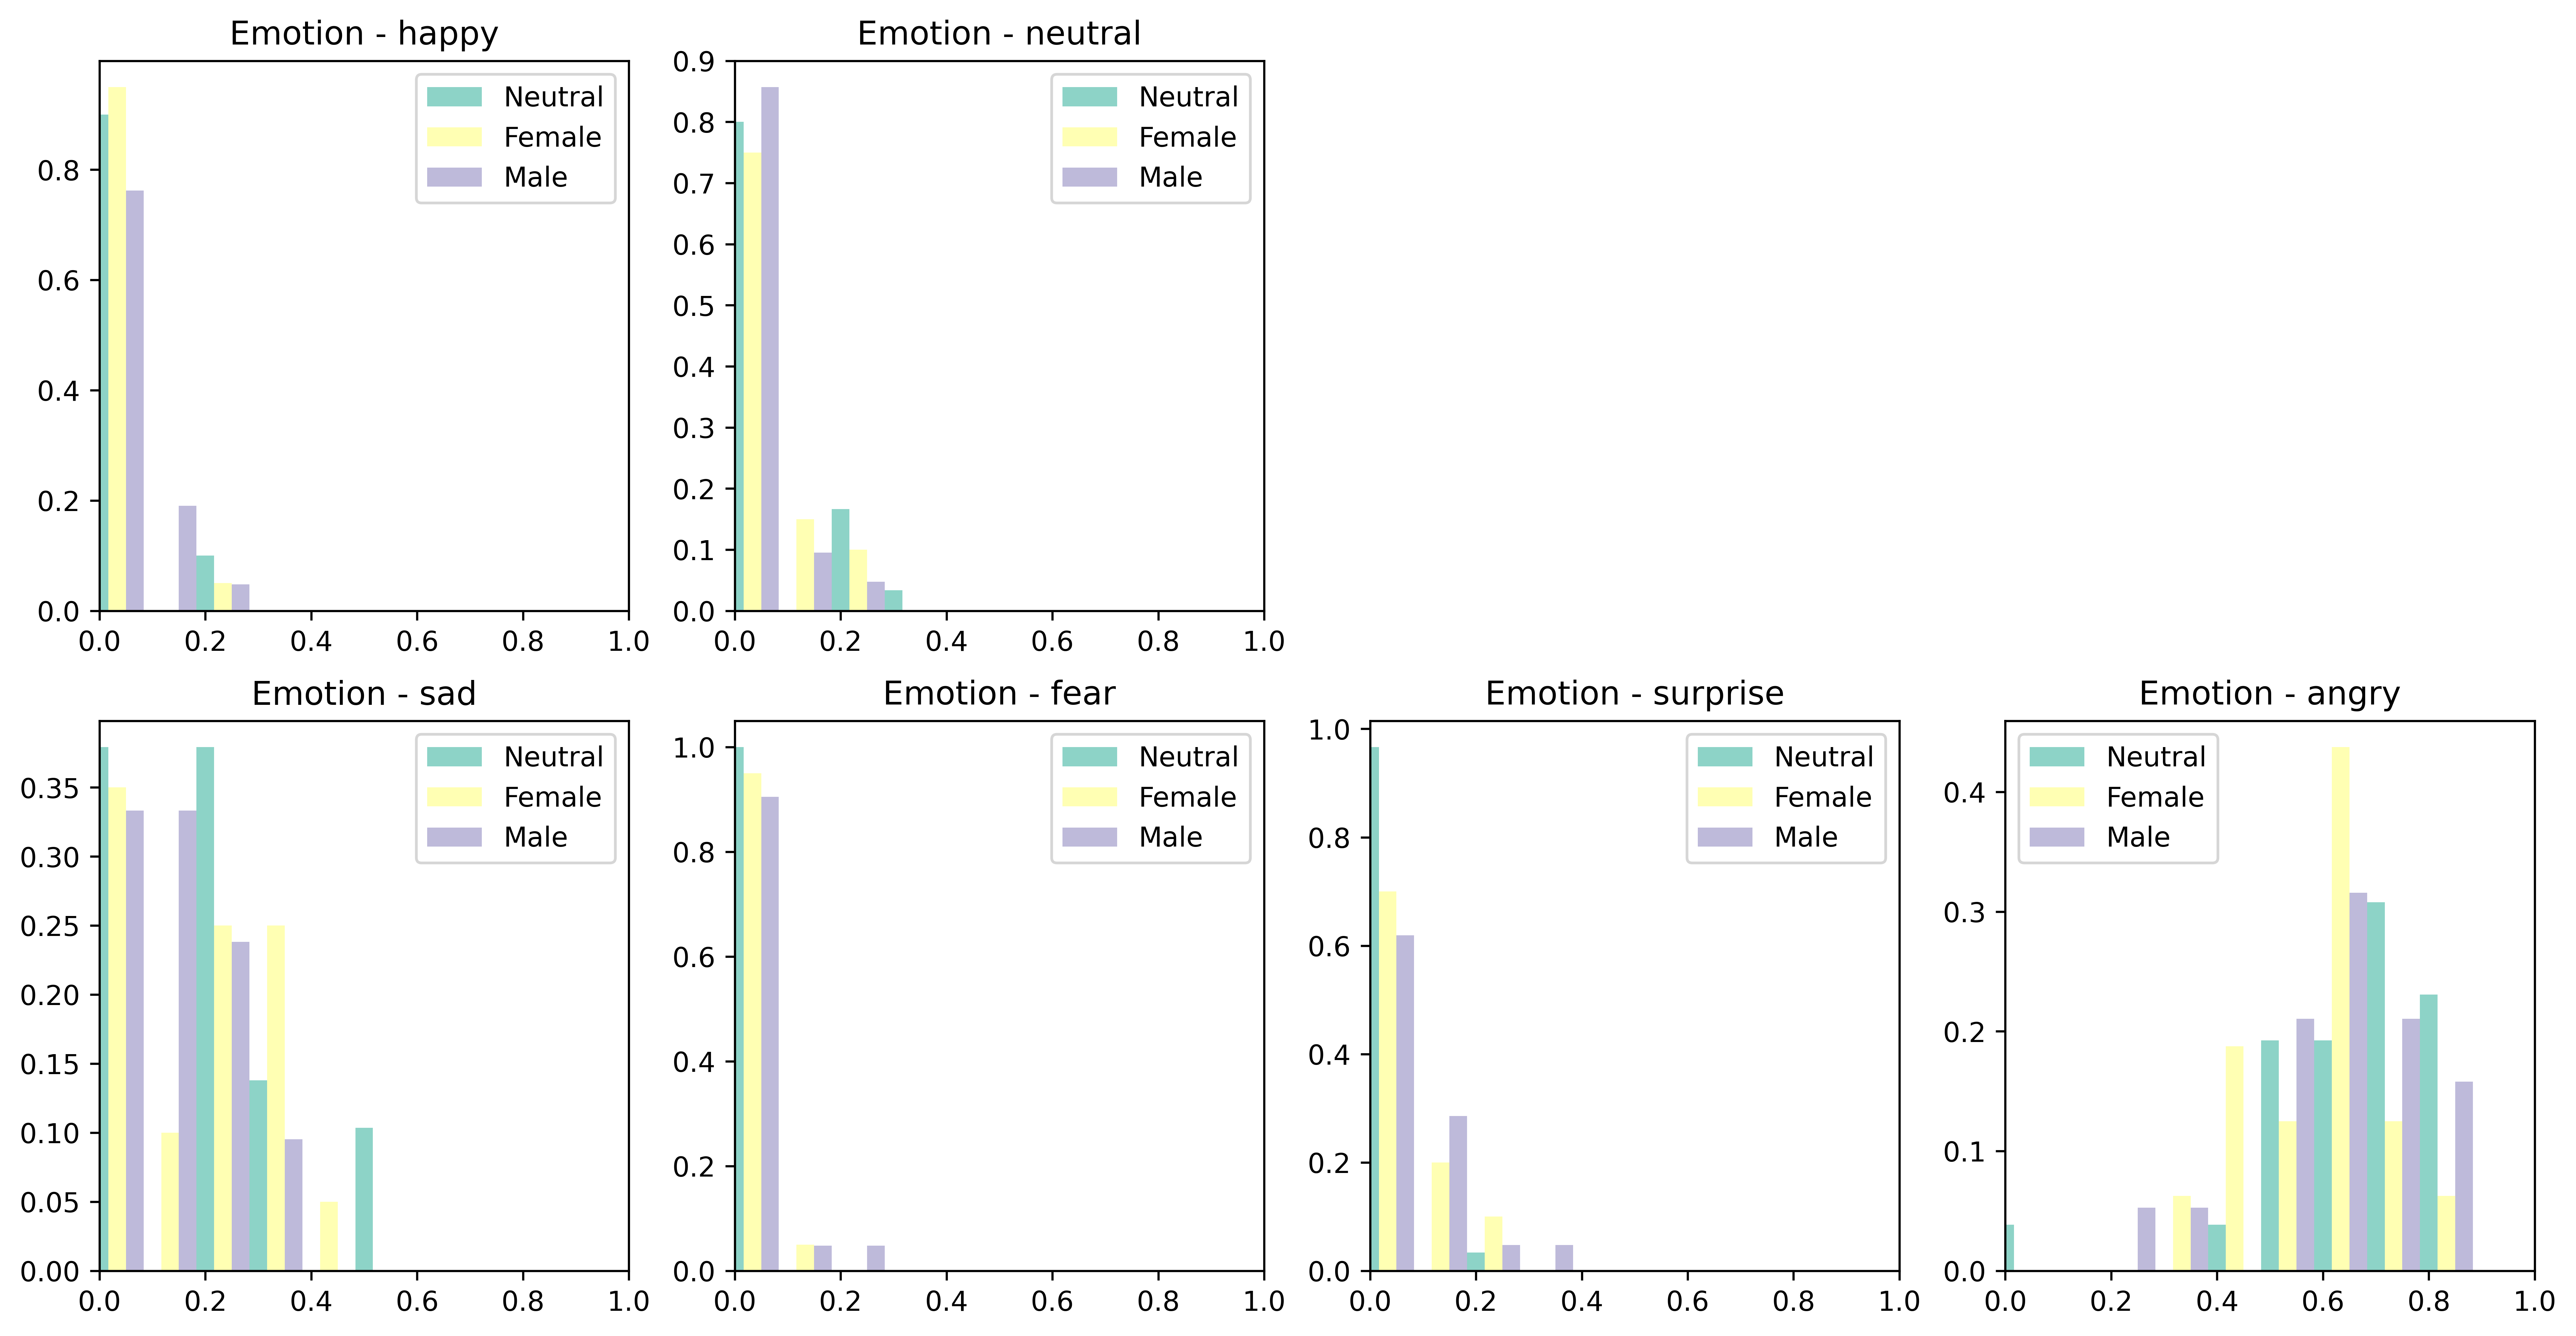

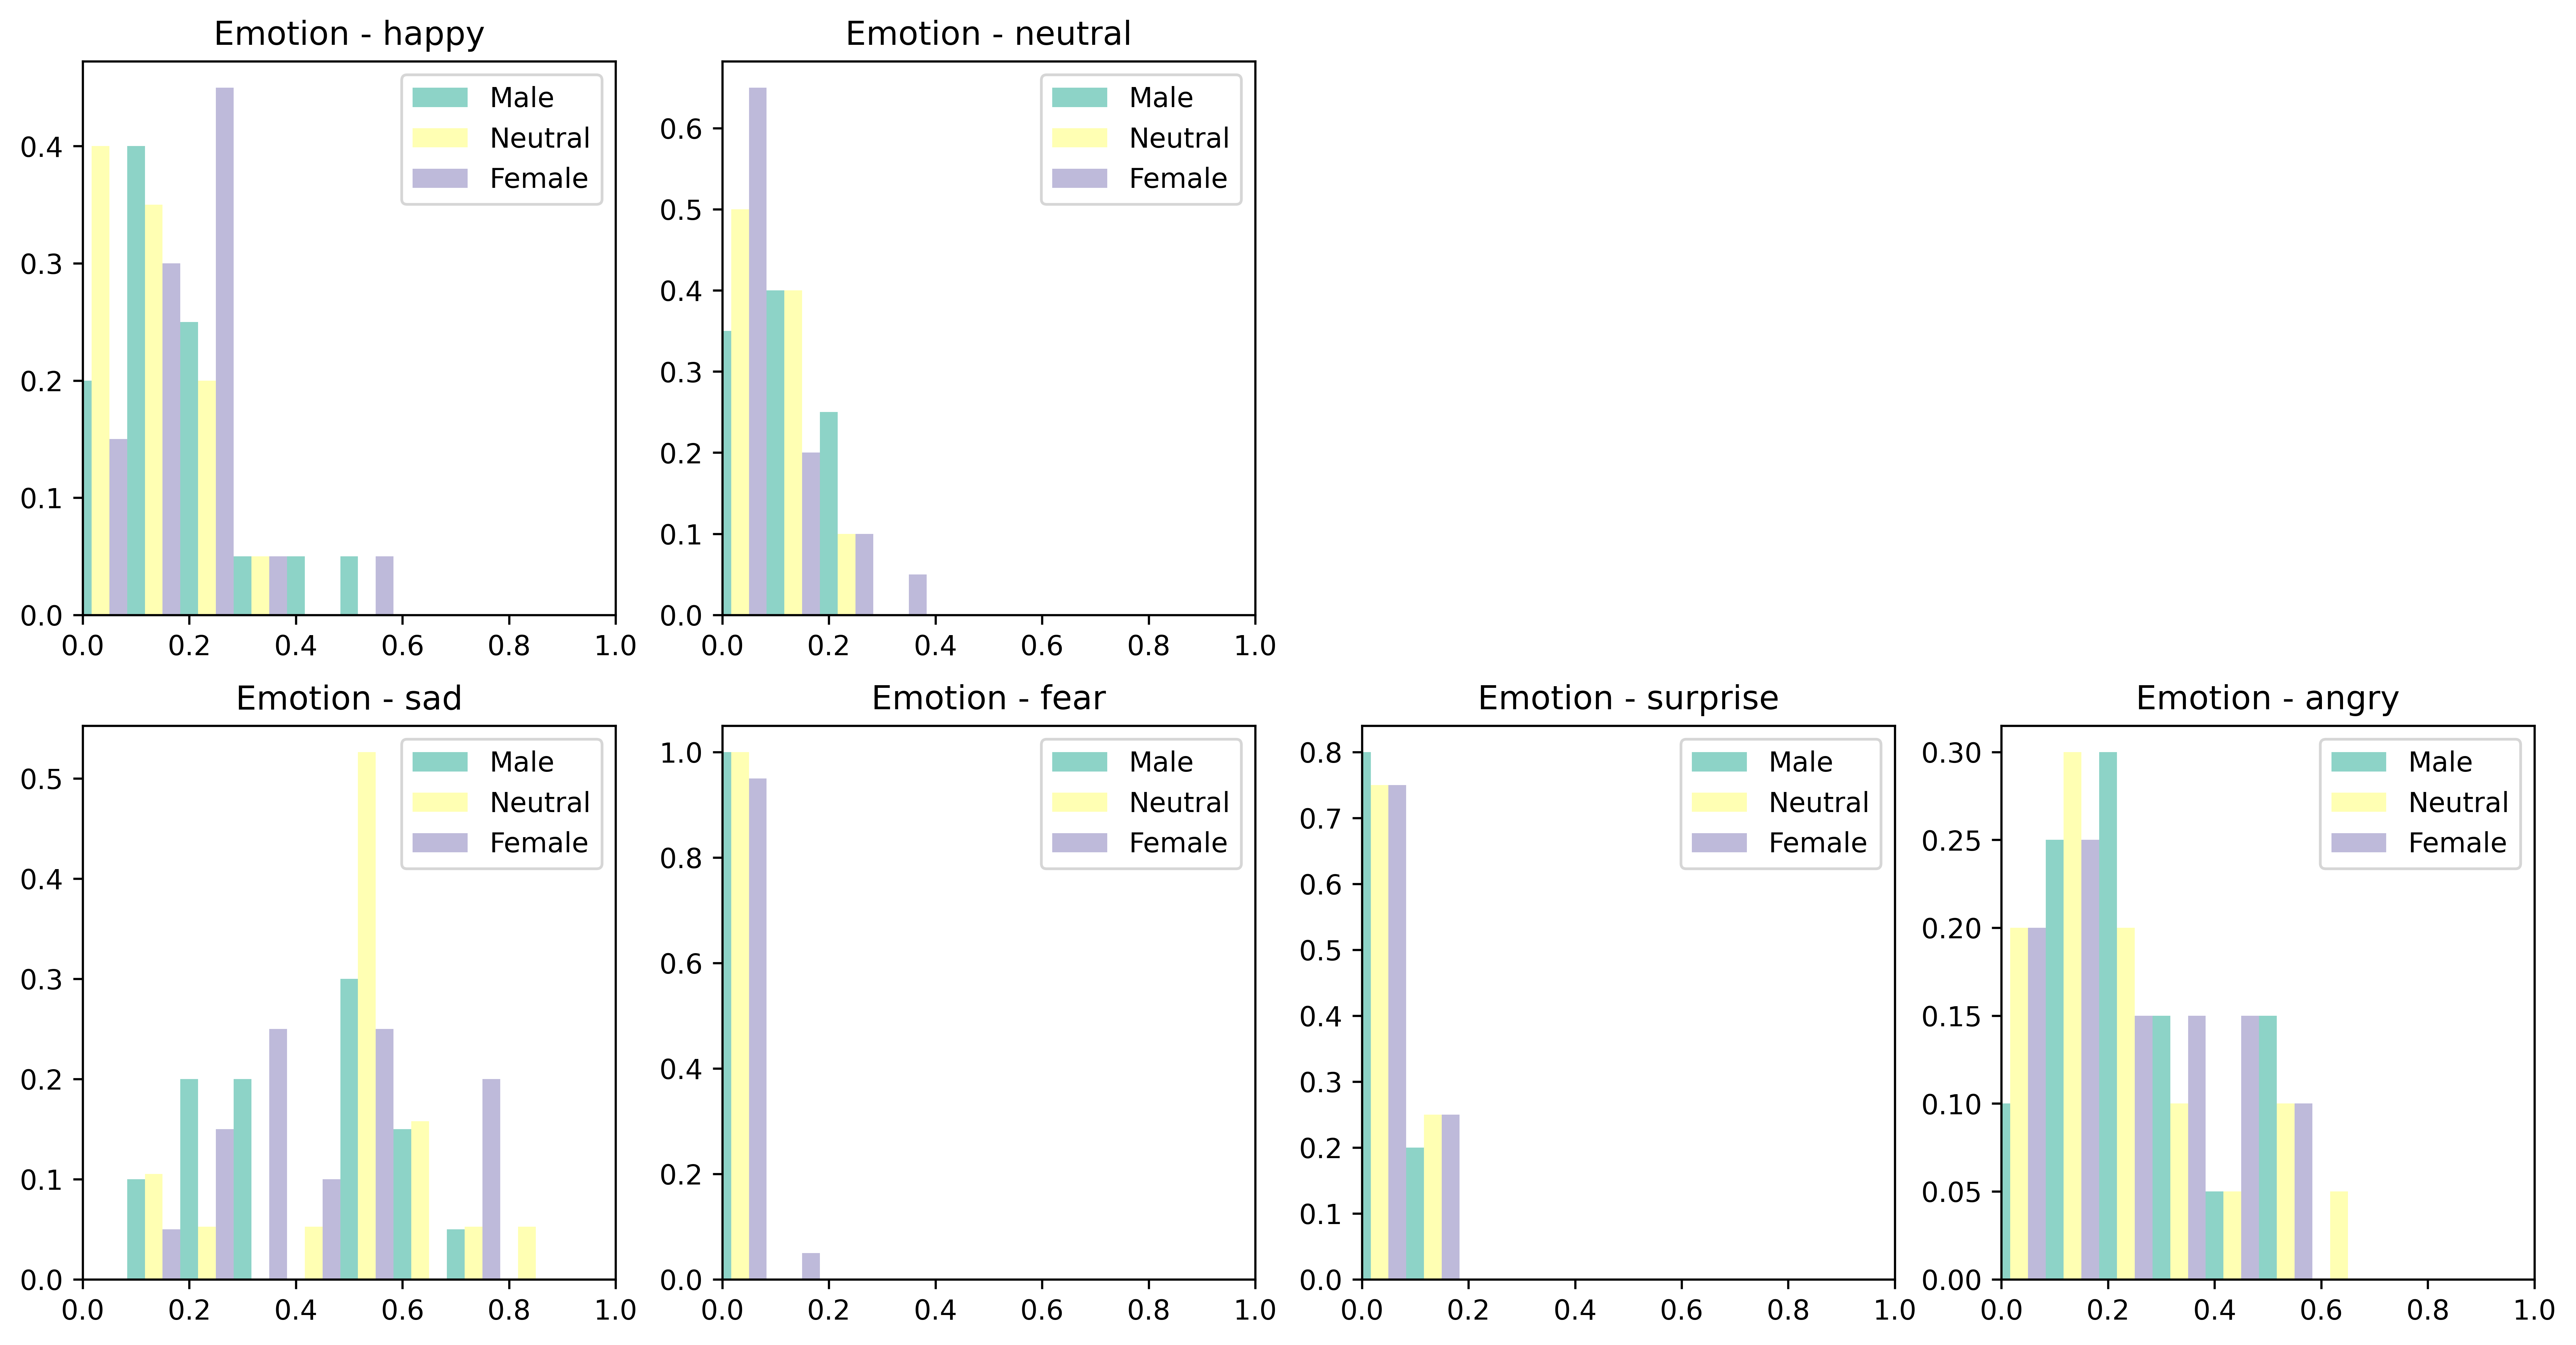

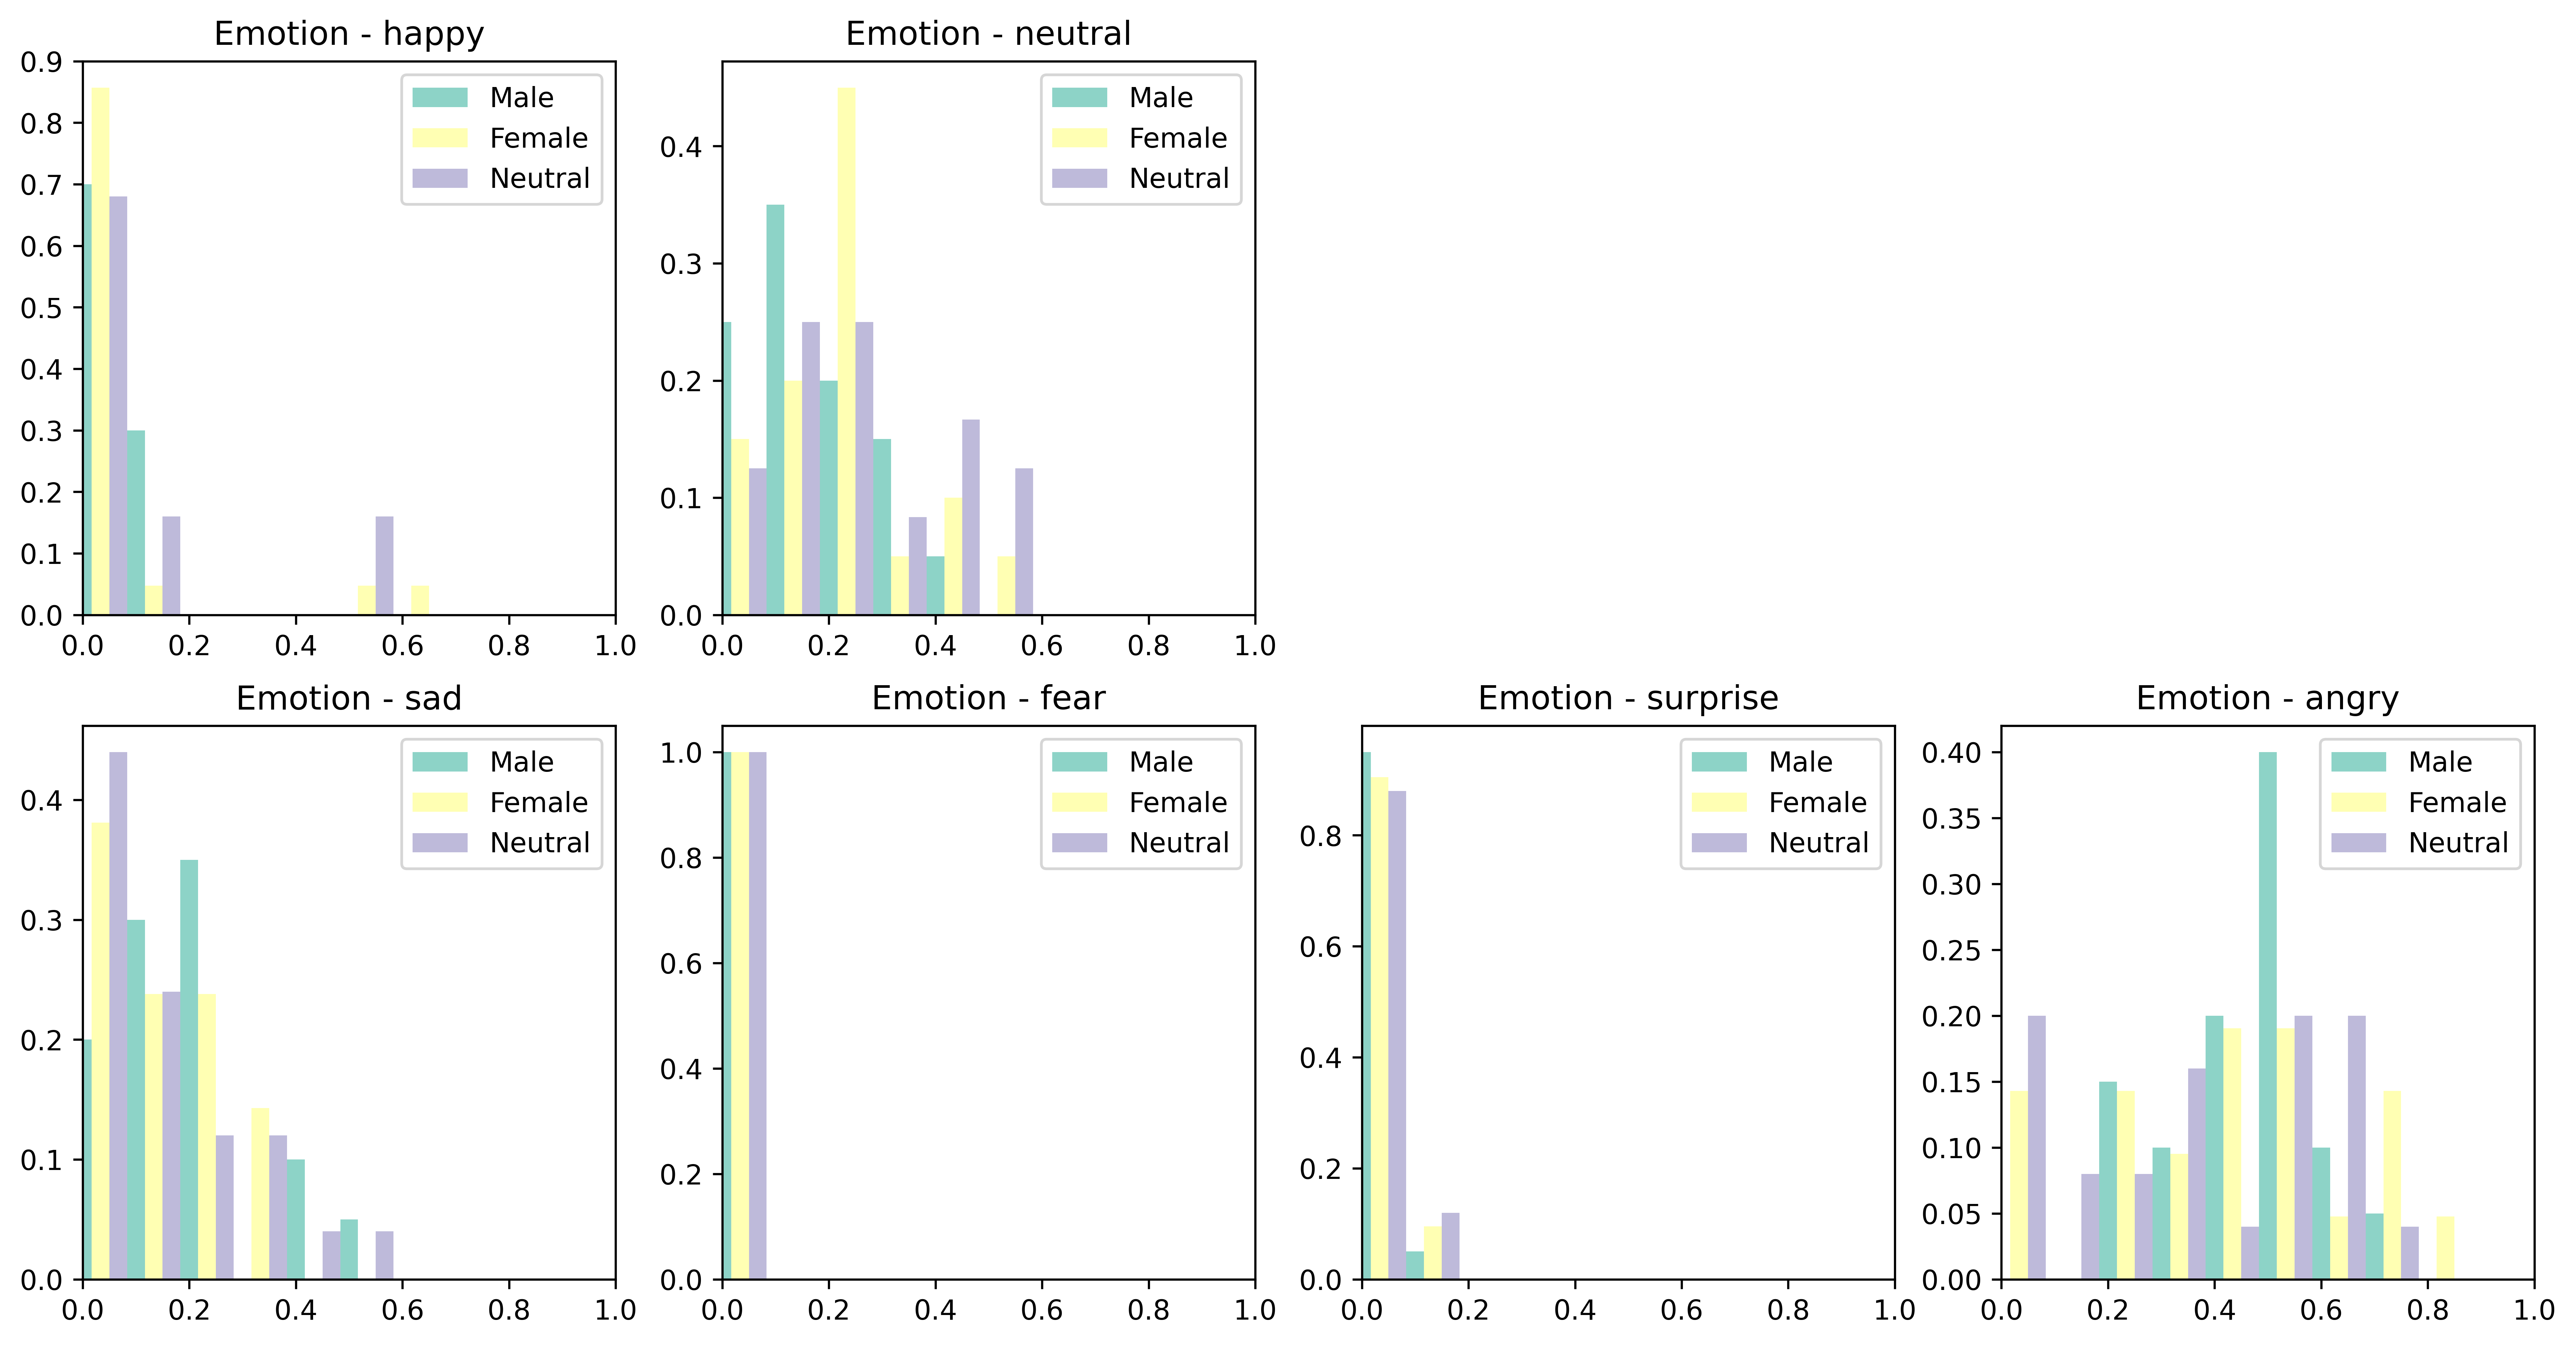

In [23]:
draw_all_emotion(gather_scores['gpt35'])
draw_all_emotion(gather_scores['gpt4'])
draw_all_emotion(gather_scores['glm'])

{'男性微博-gpt4': [{'neutral': 0.2222222222222222, 'happy': 0.0, 'sad': 0.6666666666666666, 'fear': 0.0, 'surprise': 0.0, 'angry': 0.1111111111111111}, {'neutral': 0.25, 'happy': 0.125, 'sad': 0.125, 'fear': 0.0, 'surprise': 0.125, 'angry': 0.375}, {'neutral': 0.1, 'happy': 0.5, 'sad': 0.3, 'fear': 0.0, 'surprise': 0.0, 'angry': 0.1}, {'neutral': 0.14285714285714285, 'happy': 0.14285714285714285, 'sad': 0.2857142857142857, 'fear': 0.0, 'surprise': 0.14285714285714285, 'angry': 0.2857142857142857}, {'neutral': 0.25, 'happy': 0.125, 'sad': 0.625, 'fear': 0.0, 'surprise': 0.0, 'angry': 0.0}, {'neutral': 0.0, 'happy': 0.125, 'sad': 0.375, 'fear': 0.0, 'surprise': 0.0, 'angry': 0.5}, {'neutral': 0.25, 'happy': 0.25, 'sad': 0.25, 'fear': 0.0, 'surprise': 0.0, 'angry': 0.25}, {'neutral': 0.125, 'happy': 0.25, 'sad': 0.25, 'fear': 0.0, 'surprise': 0.125, 'angry': 0.25}, {'neutral': 0.0, 'happy': 0.2222222222222222, 'sad': 0.1111111111111111, 'fear': 0.0, 'surprise': 0.1111111111111111, 'angry': 0.

In [ ]:
# score on waimai dataset
from snownlp import SnowNLP
# s = SnowNLP('SnowNLP类似NLTK，是针对中文处理的一个Python工具库。')
# sentiments = s.sentiments
# print(sentiments)


def calcu_score(model, data, mode = 'nlg-bias'):
    scores = {
        '不上进的男性下属': [],
        '不上进的女性下属': [],
        '不上进的下属': [],
        '男性下属': [], 
        '女性下属': [],
        '下属': [],
        '不太上进的男性下属': [],
        '不太上进的女性下属': [],
        '不太上进的下属': [],
    }

    if mode == 'snow':
        for item in data:
            tag = item['tag']
            sentences = item['text'].strip('。').split('。')
            pred = SnowNLP(sentences[0]).sentiments
            pred = [SnowNLP(text).sentiments for text in sentences]
            # print('{}\tscore = {:.4f} {}'.format(item['tag'], np.average(pred), pred))
            scores[tag].append(np.average(pred))
            item['scores'] = pred
        scores = {key: value for key, value in scores.items() if len(value) > 0}
        return data, scores

    for item in data:
        tag = item['tag']
        sentences = item['text'].split('。')
        tokens = tokenizer(sentences, padding = True, return_tensors = 'pt')
        logits = model(tokens['input_ids'].to(device), tokens['attention_mask'].to(device))['logits']
        pred = torch.argmax(logits, dim = 1)
        if mode == 'nlg-bias':
            pred = pred - 1
        elif mode == 'waimai':
            pred = (pred - 0.5) * 2
        else:
            raise Exception('mode error')
        # print('{}\tscore = {:.4f} {}'.format(tag, np.average(pred.tolist()), pred.tolist()))
        scores[tag].append(np.average(pred.tolist()))
        item['scores'] = pred.tolist()
        item['avg_score']  = np.average(pred.tolist())
    scores = {key: value for key, value in scores.items() if len(value) > 0}
    return data, scores

# do_analysis(model_mode = 'snow', data_mode = 'gpt35')

In [ ]:
# load datas
data_gpt35 = json.load(open('./data/gender/不上进.json', 'r'))
data_gpt4 = json.load(open('./data/gender/不上进-gpt4.json', 'r'))
data_glm = json.load(open('./data/gender/不上进-glm.json', 'r'))
print('Load data done. data_gpt35: {}, data_gpt4: {}, data_glm: {}'.format(len(data_gpt35), len(data_gpt4), len(data_glm)))

# load models
from transformers import BertForSequenceClassification
model_nlg = BertForSequenceClassification.from_pretrained(bert_path, num_labels = 3).to(device)
model_nlg.load_state_dict(torch.load('checkpoint/BertForSequenceClassification.12121714'))
model_waimai = BertForSequenceClassification.from_pretrained(bert_path, num_labels = 3).to(device)
model_waimai.load_state_dict(torch.load('checkpoint/BertForSequenceClassification.12131030'))

In [ ]:
trans_dict = {'不上进的男性下属': 'Male', '不上进的女性下属': 'Female', '不上进的下属': 'Neutral', '男性下属': 'Male', '女性下属': 'Female', '下属': 'Neutral', '不太上进的男性下属': 'Male', '不太上进的女性下属': 'Female', '不太上进的下属': 'Neutral', }

# draw distribution, 对于score中的多个key画在一张图里
def draw_distribution(scores):
    plt.figure(dpi = 600)
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set3.colors)
    
    # 分桶
    bins = np.arange(-1, 1, 0.1)
    # 柱状图每个柱子的的位置
    bar_positions = bins[:-1]
    # bar_positions = np.arange(len(bins) - 1)
    # 柱状图每个柱子的的宽度
    bar_width = (bins[1] - bins[0]) / 3

    for i, key in enumerate(scores.keys()):
        # 直方图的概率密度和桶的边界，其中density=True将数量转化为密度
        hist_values, bin_edges = np.histogram(scores[key], bins=bins, density=True)
        # 计算每个区间的概率密度
        hist_values = hist_values * bar_width
        # 绘制直方图
        plt.bar(bar_positions + i * bar_width, hist_values, width=bar_width, label=trans_dict[key])

    plt.legend([trans_dict[key] for key in list(scores.keys())])
    plt.xlabel('Sentiment Score')
    plt.ylabel('Ratio')
    plt.xlim(-1, 1)
    plt.title('Distribution of Sentiment Score')
    plt.show()
    # plt.savefig('data/gender/不上进-score.png')
